In [10]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import math

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import CSVLogger

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import  train_test_split
from sklearn.cross_validation import cross_val_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import scorer
from sklearn.metrics import accuracy_score

In [11]:
sharpes = pd.DataFrame(columns=['STOCK','ANN','SVM','KNN','LR','acc_ANN_train','acc_ANN_test','acc_SVM_train','acc_SVM_test','acc_KNN_train','acc_KNN_test','acc_LR_train','acc_LR_test'])

In [12]:
stock_name = 'GE'
df = pd.read_csv('all_stocks_5yr.csv')
df = df.drop(['volume'], axis=1)
stock_names = df.Name.unique()

In [13]:
def extract_stock(stock_name):
    df_stock = df.loc[df['Name'] == stock_name]
    df_stock = df_stock.drop(['Name'], axis=1)
    df_stock = df_stock.dropna()
    df_stock['date'] = pd.to_datetime(df_stock['date'])
    df_stock['close'] = pd.to_numeric(df_stock['close'], downcast='float')
    df_stock.set_index('date',inplace=True)
    df_stock.sort_index(inplace=True)
    
    return df_stock

In [ ]:
############################################################################################
################################### 0. ALL SCRIPTS START ###################################
############################################################################################

In [ ]:
### ANN

#get stock
df_stock = extract_stock(stock_name)

#prepare variables
df_stock['H-L'] = df_stock['high'] - df_stock['low']
df_stock['O-C'] = df_stock['close'] - df_stock['open']
df_stock['3day MA'] = df_stock['close'].shift(1).rolling(window = 3).mean()
df_stock['10day MA'] = df_stock['close'].shift(1).rolling(window = 10).mean()
df_stock['30day MA'] = df_stock['close'].shift(1).rolling(window = 30).mean()
df_stock['Std_dev']= df_stock['close'].rolling(5).std()

#prepare predicted
df_stock['Price_Rise'] = np.where(df_stock['close'].shift(-1) > df_stock['close'], 1, 0)
    
#remove na after shift
df_stock = df_stock.dropna()
    
#define X
X = df_stock.iloc[:, 4:-1]
    
#define y
y = df_stock.iloc[:, -1]
    
#define split
split_percentage = 0.8
split = int(len(df_stock)*split_percentage)
    
#prepare train and test sets
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
#define scaler
sc = StandardScaler()
    
#scale-replace X_train and X_test
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
    
#define model
classifier = Sequential()
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    
#teach model
csv_logger = CSVLogger('log.csv', append=False, separator=',')
history = classifier.fit(X_train, y_train, batch_size = 10, epochs = 10, verbose = 1, callbacks=[csv_logger], validation_data=(X_test, y_test))

y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)
    
df_stock['y_pred'] = np.NaN
df_stock.iloc[(len(df_stock) - len(y_pred)):,-1:] = y_pred
df_stock = df_stock.dropna()

#create metric
score = classifier.evaluate(X_test, y_test, verbose=1)

accuracy_train_ANN = history.history['acc'][-1]
accuracy_test_ANN = score[1]

#calculate returns
df_stock['Tomorrows Returns'] = 0.
df_stock['Tomorrows Returns'] = np.log(df_stock['close']/df_stock['close'].shift(1))
df_stock['Tomorrows Returns'] = df_stock['Tomorrows Returns'].shift(-1)

df_stock['Strategy Returns'] = 0.
df_stock['Strategy Returns'] = np.where(df_stock['y_pred'] == True, df_stock['Tomorrows Returns'], - df_stock['Tomorrows Returns'])

df_stock['Cumulative Market Returns'] = np.cumsum(df_stock['Tomorrows Returns'])
df_stock['Cumulative Strategy Returns'] = np.cumsum(df_stock['Strategy Returns'])

Cumulative_Strategy_Returns = df_stock['Cumulative Strategy Returns']*100
Cumulative_Market_Returns = df_stock['Cumulative Market Returns']*100

Cumulative_ANN_Returns = Cumulative_Strategy_Returns

#calculate sharpe ratio
Std = Cumulative_Strategy_Returns.std()
Sharpe = (Cumulative_Strategy_Returns-Cumulative_Market_Returns)/Std
Sharpe_ANN = Sharpe.mean()

In [ ]:
### SVM

#get stock
df_stock = extract_stock(stock_name)
    
#prepare variables
df_stock['H-L'] = df_stock['high'] - df_stock['low']
df_stock['O-C'] = df_stock['close'] - df_stock['open']
df_stock['3day MA'] = df_stock['close'].shift(1).rolling(window = 3).mean()
df_stock['10day MA'] = df_stock['close'].shift(1).rolling(window = 10).mean()
df_stock['30day MA'] = df_stock['close'].shift(1).rolling(window = 30).mean()
df_stock['Std_dev']= df_stock['close'].rolling(5).std()
    
#prepare predicted
df_stock['Price_Rise'] = np.where(df_stock['close'].shift(-1) > df_stock['close'], 1, 0)
    
#remove na after shift
df_stock = df_stock.dropna()
    
#define X
X = df_stock.iloc[:, 4:-1]
    
#define y
y = np.where(df_stock['close'].shift(-1) > df_stock['close'],1,-1)
    
#define split
split_percentage = 0.8
split = int(len(df_stock)*split_percentage)
    
#prepare train and test sets
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
#define and teach model
cls = SVC().fit(X_train, y_train)
    
#create metrics
accuracy_train_svm = accuracy_score(y_train, cls.predict(X_train))
accuracy_test_svm = accuracy_score(y_test, cls.predict(X_test))
    
#calculate returns
df_stock['Predicted_Signal'] = cls.predict(X)
df_stock['Market_Returns'] = np.log(df_stock['close']/df_stock['close'].shift(1))
Cumulative_Market_Returns = df_stock[split:]['Market_Returns'].cumsum()*100

df_stock['Strategy_Returns'] = df_stock['Market_Returns'] * df_stock['Predicted_Signal'].shift(1)
Cumulative_Strategy_Returns = df_stock[split:]['Strategy_Returns'].cumsum()*100

Cumulative_SVM_Returns = Cumulative_Strategy_Returns

#calculate sharpe ratio
Std = Cumulative_Strategy_Returns.std()
Sharpe = (Cumulative_Strategy_Returns-Cumulative_Market_Returns)/Std
Sharpe_SVM = Sharpe.mean()
    
#return Sharpe_SVM

In [ ]:
# KNN

#get stock
df_stock = extract_stock(stock_name)
    
#prepare variables
df_stock['H-L'] = df_stock['high'] - df_stock['low']
df_stock['O-C'] = df_stock['close'] - df_stock['open']
df_stock['3day MA'] = df_stock['close'].shift(1).rolling(window = 3).mean()
df_stock['10day MA'] = df_stock['close'].shift(1).rolling(window = 10).mean()
df_stock['30day MA'] = df_stock['close'].shift(1).rolling(window = 30).mean()
df_stock['Std_dev']= df_stock['close'].rolling(5).std()
    
#prepare predicted
df_stock['Price_Rise'] = np.where(df_stock['close'].shift(-1) > df_stock['close'],1,-1)
    
#remove na after shift
df_stock = df_stock.dropna()
    
#define X
X = df_stock.iloc[:, 4:-1]
    
#define y
y = np.where(df_stock['close'].shift(-1) > df_stock['close'],1,-1)
    
#define split
split_percentage = 0.8
split = int(split_percentage*len(df_stock))

#prepare train and test sets
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
#define and teach model
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
    
#create metrics
accuracy_train_knn = accuracy_score(y_train, knn.predict(X_train))
accuracy_test_knn = accuracy_score(y_test, knn.predict(X_test))
    
#calculate returns
df_stock['Predicted_Signal'] = knn.predict(X)
df_stock['Market_Returns'] = np.log(df_stock['close']/df_stock['close'].shift(1))
Cumulative_Market_Returns = df_stock[split:]['Market_Returns'].cumsum()*100

df_stock['Strategy_Returns'] = df_stock['Market_Returns'] * df_stock['Predicted_Signal'].shift(1)
Cumulative_Strategy_Returns = df_stock[split:]['Strategy_Returns'].cumsum()*100

Cumulative_KNN_Returns = Cumulative_Strategy_Returns

#calculate sharpe ratio
Std = Cumulative_Strategy_Returns.std()
Sharpe = (Cumulative_Strategy_Returns-Cumulative_Market_Returns)/Std
Sharpe_KNN = Sharpe.mean()
    
#return Sharpe_KNN

In [ ]:
### LR

#get stock
df_stock = extract_stock(stock_name)
    
#prepare variables
df_stock['H-L'] = df_stock['high'] - df_stock['low']
df_stock['O-C'] = df_stock['close'] - df_stock['open']
df_stock['3day MA'] = df_stock['close'].shift(1).rolling(window = 3).mean()
df_stock['10day MA'] = df_stock['close'].shift(1).rolling(window = 10).mean()
df_stock['30day MA'] = df_stock['close'].shift(1).rolling(window = 30).mean()
df_stock['Std_dev']= df_stock['close'].rolling(5).std()
df_stock = df_stock.dropna()
    
#prepare predicted
df_stock['Price_Rise'] = np.where(df_stock['close'].shift(-1) > df_stock['close'], 1, 0)
    
#define X
X = df_stock.iloc[:, 4:-1]
    
#define y
y = np.where(df_stock['close'].shift(-1) > df_stock['close'],1,-1)

#define split
split_percentage = 0.8
split = int(split_percentage*len(df_stock))
    
#prepare train and test sets
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
#define and teach model
model = LogisticRegression()
model = model.fit(X_train,y_train)
    
#create metrics
accuracy_train_lr = accuracy_score(y_train, model.predict(X_train))
accuracy_test_lr = accuracy_score(y_test, model.predict(X_test))

pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))
probability = model.predict_proba(X_test)
predicted = model.predict(X_test)
probability = model.predict_proba(X_test)
metrics.confusion_matrix(y_test, predicted)
metrics.classification_report(y_test, predicted)
model.score(X_test,y_test)
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
cross_val.mean()
    
#calculate returns
df_stock['Predicted_Signal'] = model.predict(X)
df_stock['Market_Returns'] = np.log(df_stock['close']/df_stock['close'].shift(1))
Cumulative_Market_Returns = df_stock[split:]['Market_Returns'].cumsum()*100

df_stock['Strategy_Returns'] = df_stock['Market_Returns'] * df_stock['Predicted_Signal'].shift(1)
Cumulative_Strategy_Returns = df_stock[split:]['Strategy_Returns'].cumsum()*100

Cumulative_LR_Returns = Cumulative_Strategy_Returns

#calculate sharpe ratio
Std = Cumulative_Strategy_Returns.std()
Sharpe = (Cumulative_Strategy_Returns-Cumulative_Market_Returns)/Std
Sharpe_LR = Sharpe.mean()
    
#return Sharpe_LR

In [ ]:
df_stock = df.loc[df['Name'] == stock_name]

df_stock['date'] = pd.to_datetime(df_stock['date'])
df_stock['close'] = pd.to_numeric(df_stock['close'], downcast='float')

df_stock.set_index('date',inplace=True)  
df_stock.sort_index(inplace=True)  

df_stock.head()

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(Cumulative_Market_Returns, color='r', label='Market Returns')
plt.plot(Cumulative_ANN_Returns, color='g', label='ANN Returns')
plt.plot(Cumulative_SVM_Returns, color='b', label='SVM Returns')
plt.plot(Cumulative_KNN_Returns, color='m', label='KNN Returns')
plt.plot(Cumulative_LR_Returns, color='c', label='LR Returns')
plt.grid()
plt.legend()
plt.show()

In [ ]:
df_stock = df_stock.loc['2017-02-01':'2018-02-01']
plt.figure(figsize=(15,8))
plt.plot(df_stock['close'], color='g', label='Close')
plt.grid()
plt.legend()
plt.show()

In [ ]:
print('accuracy_train_knn: ' + str(accuracy_train_knn))
print('accuracy_train_lr: ' + str(accuracy_train_lr))
print('accuracy_train_svm: ' + str(accuracy_train_svm))

print('accuracy_test_knn: ' + str(accuracy_test_knn))
print('accuracy_test_lr: ' + str(accuracy_test_lr))
print('accuracy_test_svm: ' + str(accuracy_test_svm))

In [ ]:
##########################################################################################
################################### 0. ALL SCRIPTS END ###################################
##########################################################################################

In [ ]:
###################################################################################################
################################### 1. START OF NEURAL NETWORKS ###################################
###################################################################################################

In [25]:
def ANN(df, stock_name):
    
    #get stock
    df_stock = extract_stock(stock_name)
    
    #prepare variables
    df_stock['H-L'] = df_stock['high'] - df_stock['low']
    df_stock['O-C'] = df_stock['close'] - df_stock['open']
    df_stock['3day MA'] = df_stock['close'].shift(1).rolling(window = 3).mean()
    df_stock['10day MA'] = df_stock['close'].shift(1).rolling(window = 10).mean()
    df_stock['30day MA'] = df_stock['close'].shift(1).rolling(window = 30).mean()
    df_stock['Std_dev']= df_stock['close'].rolling(5).std()
    
    #prepare predicted
    df_stock['Price_Rise'] = np.where(df_stock['close'].shift(-1) > df_stock['close'], 1, 0)
    
    #remove na after shift
    df_stock = df_stock.dropna()
    
    #define X
    X = df_stock.iloc[:, 4:-1]
    
    #define y
    y = df_stock.iloc[:, -1]
    
    #define split
    split_percentage = 0.8
    split = int(len(df_stock)*split_percentage)
    
    #prepare train and test sets
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
    #define scaler
    sc = MinMaxScaler(feature_range=(0,1))
    
    #scale-replace X_train and X_test
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    #define model
    classifier = Sequential()
    classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu', input_dim = X.shape[1]))
    classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    
    #fit model
    history = classifier.fit(X_train, y_train, batch_size = 10, epochs = 150, verbose = 0, validation_data=(X_test, y_test))
    y_pred = classifier.predict(X_test)
    y_pred = (y_pred > 0.5)
    
    df_stock['y_pred'] = np.NaN
    df_stock.iloc[(len(df_stock) - len(y_pred)):,-1:] = y_pred
    trade_dataset = df_stock.dropna()
    
    #create metrics
    score = classifier.evaluate(X_test, y_test, verbose=1)
    accuracy_train_ANN = history.history['acc'][-1]
    accuracy_test_ANN = score[1]
    
    #calculate returns
    df_stock['Tomorrows Returns'] = 0.
    df_stock['Tomorrows Returns'] = np.log(df_stock['close']/df_stock['close'].shift(1))
    df_stock['Tomorrows Returns'] = df_stock['Tomorrows Returns'].shift(-1)

    df_stock['Strategy Returns'] = 0.
    df_stock['Strategy Returns'] = np.where(df_stock['y_pred'] == True, df_stock['Tomorrows Returns'], - df_stock['Tomorrows Returns'])

    df_stock['Cumulative Market Returns'] = np.cumsum(df_stock[split:]['Tomorrows Returns'])*100
    df_stock['Cumulative Strategy Returns'] = np.cumsum(df_stock[split:]['Strategy Returns'])*100

    Cum_Strategy_Returns = df_stock['Cumulative Strategy Returns']
    Cumulative_Market_Returns = df_stock['Cumulative Market Returns']
    
    #calculate sharpe ratio
    Std = Cum_Strategy_Returns.std()
    Sharpe = (Cum_Strategy_Returns-Cumulative_Market_Returns)/Std
    Sharpe_ANN = Sharpe.mean()
    
    return (Sharpe_ANN, accuracy_train_ANN, accuracy_test_ANN, Cum_Strategy_Returns, Cumulative_Market_Returns)

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(Cumulative_Strategy_Returns, color='g', label='Strategy Returns')
plt.plot(Cumulative_Market_Returns, color='r', label='Market Returns')
plt.legend()
plt.show()

In [ ]:
#################################################################################################
################################### 1. END OF NEURAL NETWORKS ###################################
#################################################################################################

In [ ]:
###################################################################################################
################################### 2. STARY OF SUPPORT VECTORS ###################################
###################################################################################################

In [6]:
def SVM(df, stock_name):
    
    #get stock
    df_stock = extract_stock(stock_name)
    
    #prepare variables
    df_stock['H-L'] = df_stock['high'] - df_stock['low']
    df_stock['O-C'] = df_stock['close'] - df_stock['open']
    df_stock['3day MA'] = df_stock['close'].shift(1).rolling(window = 3).mean()
    df_stock['10day MA'] = df_stock['close'].shift(1).rolling(window = 10).mean()
    df_stock['30day MA'] = df_stock['close'].shift(1).rolling(window = 30).mean()
    df_stock['Std_dev']= df_stock['close'].rolling(5).std()
    
    #prepare predicted
    df_stock['Price_Rise'] = np.where(df_stock['close'].shift(-1) > df_stock['close'], 1, 0)
    
    #remove na after shift
    df_stock = df_stock.dropna()
    
    #define X
    X = df_stock.iloc[:, 4:-1]
    
    #define y
    y = np.where(df_stock['close'].shift(-1) > df_stock['close'],1,-1)
    
    #define split
    split_percentage = 0.8
    split = int(len(df_stock)*split_percentage)
    
    #prepare train and test sets
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
    #define and teach model
    cls = SVC().fit(X_train, y_train)
    
    #create metrics
    accuracy_train_SVM = accuracy_score(y_train, cls.predict(X_train))
    accuracy_test_SVM = accuracy_score(y_test, cls.predict(X_test))
    
    #calculate returns
    df_stock['Predicted_Signal'] = cls.predict(X)
    df_stock['Market_Returns'] = np.log(df_stock['close']/df_stock['close'].shift(1))
    Cumulative_Market_Returns = df_stock[split:]['Market_Returns'].cumsum()*100

    df_stock['Strategy_Returns'] = df_stock['Market_Returns'] * df_stock['Predicted_Signal'].shift(1)
    Cumulative_Strategy_Returns = df_stock[split:]['Strategy_Returns'].cumsum()*100
    
    #calculate sharpe ratio
    Std = Cumulative_Strategy_Returns.std()
    Sharpe = (Cumulative_Strategy_Returns-Cumulative_Market_Returns)/Std
    Sharpe_SVM = Sharpe.mean()
    
    return (Sharpe_SVM, accuracy_train_SVM, accuracy_test_SVM, Cumulative_Strategy_Returns, Cumulative_Market_Returns)

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(Cumulative_Strategy_Returns, color='g', label='Strategy Returns')
plt.plot(Cumulative_Market_Returns, color='r', label='Market Returns')
plt.legend()
plt.show()

In [ ]:
############################################################
################################### 2. END OF SUPPORT VECTORS ###################################
#################################################################################################

In [ ]:
#######################################################################################
################################### 3. START OF KNN ###################################
#######################################################################################

In [7]:
def KNN(df, stock_name):
    
    #get stock
    df_stock = extract_stock(stock_name)
    
    #prepare variables
    df_stock['H-L'] = df_stock['high'] - df_stock['low']
    df_stock['O-C'] = df_stock['close'] - df_stock['open']
    df_stock['3day MA'] = df_stock['close'].shift(1).rolling(window = 3).mean()
    df_stock['10day MA'] = df_stock['close'].shift(1).rolling(window = 10).mean()
    df_stock['30day MA'] = df_stock['close'].shift(1).rolling(window = 30).mean()
    df_stock['Std_dev']= df_stock['close'].rolling(5).std()
    
    #prepare predicted
    df_stock['Price_Rise'] = np.where(df_stock['close'].shift(-1) > df_stock['close'],1,-1)
    
    #remove na after shift
    df_stock = df_stock.dropna()
    
    #define X
    X = df_stock.iloc[:, 4:-1]
    
    #define y
    y = np.where(df_stock['close'].shift(-1) > df_stock['close'],1,-1)
    
    #define split
    split_percentage = 0.8
    split = int(split_percentage*len(df_stock))

    #prepare train and test sets
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
    #define and teach model
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(X_train, y_train)
    
    #create metrics
    accuracy_train_KNN = accuracy_score(y_train, knn.predict(X_train))
    accuracy_test_KNN = accuracy_score(y_test, knn.predict(X_test))
    
    #calculate returns
    df_stock['Predicted_Signal'] = knn.predict(X)
    df_stock['Market_Returns'] = np.log(df_stock['close']/df_stock['close'].shift(1))
    Cumulative_Market_Returns = df_stock[split:]['Market_Returns'].cumsum()*100

    df_stock['Strategy_Returns'] = df_stock['Market_Returns'] * df_stock['Predicted_Signal'].shift(1)
    Cumulative_Strategy_Returns = df_stock[split:]['Strategy_Returns'].cumsum()*100
    
    #calculate sharpe ratio
    Std = Cumulative_Strategy_Returns.std()
    Sharpe = (Cumulative_Strategy_Returns-Cumulative_Market_Returns)/Std
    Sharpe_KNN = Sharpe.mean()
    
    return (Sharpe_KNN, accuracy_train_KNN, accuracy_test_KNN, Cumulative_Strategy_Returns, Cumulative_Market_Returns)

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(Cumulative_Market_Returns, color='r', label='Market Returns')
plt.plot(Cumulative_Strategy_Returns, color='g', label='Strategy Retruns')
plt.legend()
plt.show()

In [ ]:
#####################################################################################
################################### 3. END OF KNN ###################################
#####################################################################################

In [ ]:
#######################################################################################################
################################### 4. START OF LOGISTIC REGRESSION ###################################
#######################################################################################################

In [8]:
def LR(df, stock_name):
    
    #get stock
    df_stock = extract_stock(stock_name)
    
    #prepare variables
    df_stock['H-L'] = df_stock['high'] - df_stock['low']
    df_stock['O-C'] = df_stock['close'] - df_stock['open']
    df_stock['3day MA'] = df_stock['close'].shift(1).rolling(window = 3).mean()
    df_stock['10day MA'] = df_stock['close'].shift(1).rolling(window = 10).mean()
    df_stock['30day MA'] = df_stock['close'].shift(1).rolling(window = 30).mean()
    df_stock['Std_dev']= df_stock['close'].rolling(5).std()
    df_stock = df_stock.dropna()
    
    #prepare predicted
    df_stock['Price_Rise'] = np.where(df_stock['close'].shift(-1) > df_stock['close'], 1, 0)
    
    #define X
    X = df_stock.iloc[:, 4:-1]
    
    #define y
    y = np.where(df_stock['close'].shift(-1) > df_stock['close'],1,-1)

    #define split
    split_percentage = 0.8
    split = int(split_percentage*len(df_stock))
    
    #prepare train and test sets
    X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]
    
    #define and teach model
    model = LogisticRegression()
    model = model.fit(X_train,y_train)
    
    #create metrics
    accuracy_train_LR = accuracy_score(y_train, model.predict(X_train))
    accuracy_test_LR = accuracy_score(y_test, model.predict(X_test))
    
    pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))
    probability = model.predict_proba(X_test)
    predicted = model.predict(X_test)
    probability = model.predict_proba(X_test)
    metrics.confusion_matrix(y_test, predicted)
    metrics.classification_report(y_test, predicted)
    model.score(X_test,y_test)
    cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
    cross_val.mean()
    
    #calculate returns
    df_stock['Predicted_Signal'] = model.predict(X)
    df_stock['Market_Returns'] = np.log(df_stock['close']/df_stock['close'].shift(1))
    Cumulative_Market_Returns = df_stock[split:]['Market_Returns'].cumsum()*100

    df_stock['Strategy_Returns'] = df_stock['Market_Returns'] * df_stock['Predicted_Signal'].shift(1)
    Cumulative_Strategy_Returns = df_stock[split:]['Strategy_Returns'].cumsum()*100
    
    #calculate sharpe ratio
    Std = Cumulative_Strategy_Returns.std()
    Sharpe = (Cumulative_Strategy_Returns-Cumulative_Market_Returns)/Std
    Sharpe_LR = Sharpe.mean()
    
    return (Sharpe_LR, accuracy_train_LR, accuracy_test_LR, Cumulative_Strategy_Returns, Cumulative_Market_Returns)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(Cumulative_Market_Returns, color='r',label = 'Market Returns')
plt.plot(Cumulative_Strategy_Returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

In [ ]:
#####################################################################################################
################################### 4. END OF LOGISTIC REGRESSION ###################################
#####################################################################################################

In [15]:
ge = ANN(df, 'GE')

246/246 [==============================] - 0s 16us/step


In [17]:
ge[0]

-2.327531337738037

In [ ]:
print('Sharpe ANN ratio: %.2f' %Sharpe_ANN)
print('Sharpe SVM ratio: %.2f' %Sharpe_SVM.)
print('Sharpe KNN ratio: %.2f' %Sharpe_KNN)
print('Sharpe LR ratio: %.2f' %Sharpe_LR)

In [ ]:
i = 1
for stock_name in stock_names:

    print('============= ' + str(i) + ' ===============')
    print('Analysis of ' + stock_name + ' started.')
    
    print('- ANN START -')
    sharpe_ann = ANN(df, stock_name)
    print('Sharpe ANN ratio: %.2f' %sharpe_ann[0])
    print('- ANN FINISH -')
        
    print('- SVM START -')
    sharpe_svm = SVM(df, stock_name)
    print('Sharpe SVM ratio: %.2f' %sharpe_svm[0])
    print('- SVM FINISH -')
      
    print('- KNN START -')
    sharpe_knn = KNN(df, stock_name)
    print('Sharpe KNN ratio: %.2f' %sharpe_knn[0])
    print('- KNN FINISH -')
       
    print('- LR START -')
    sharpe_lr = LR(df, stock_name)
    print('Sharpe LR ratio: %.2f' %sharpe_lr[0])
    print('- LR FINISH -')
        
    print('Analysis of ' + stock_name + ' finished.')   
    print('Dumping results to dataframe')

    sharpes = pd.DataFrame(np.array([[stock_name, sharpe_ann[0], sharpe_svm[0], sharpe_knn[0], sharpe_lr[0], sharpe_ann[1], sharpe_ann[2], sharpe_svm[1], sharpe_svm[2], sharpe_knn[1], sharpe_knn[2], sharpe_lr[1], sharpe_lr[2]]]),
                            columns=['STOCK','ANN','SVM','KNN','LR','acc_ANN_train','acc_ANN_test','acc_SVM_train','acc_SVM_test','acc_KNN_train','acc_KNN_test','acc_LR_train','acc_LR_test']).append(sharpes, ignore_index=True)
    i=i+1


============= 1 ===============
Analysis of AAL started.
- ANN START -
246/246 [==============================] - 0s 37us/step
Sharpe ANN ratio: 0.49
- ANN FINISH -
- SVM START -
Sharpe SVM ratio: -0.15
- SVM FINISH -
- KNN START -
Sharpe KNN ratio: -1.58
- KNN FINISH -
- LR START -
Sharpe LR ratio: 0.22
- LR FINISH -
Analysis of AAL finished.
Dumping results to dataframe
============= 2 ===============
Analysis of AAPL started.
- ANN START -
246/246 [==============================] - 0s 30us/step
Sharpe ANN ratio: -3.29
- ANN FINISH -
- SVM START -
Sharpe SVM ratio: -0.31
- SVM FINISH -
- KNN START -
Sharpe KNN ratio: -3.65
- KNN FINISH -
- LR START -
Sharpe LR ratio: -5.52
- LR FINISH -
Analysis of AAPL finished.
Dumping results to dataframe
============= 3 ===============
Analysis of AAP started.
- ANN START -
246/246 [==============================] - 0s 37us/step
Sharpe ANN ratio: -0.03
- ANN FINISH -
- SVM START -
Sharpe SVM ratio: 2.33
- SVM FINISH -
- KNN START -
Sharpe KNN rat

In [ ]:
col_names = list(sharpes)
for name in col_names:
    if name != 'STOCK':
        sharpes[name] = sharpes[name].astype(float)

sharpes.round(3)
sharpes.to_csv('sharpes_x.csv')

In [ ]:
sharpes

In [ ]:
########## post-processing
### get 5 names with highest sharpe for each algorithm
top5_ann = sharpes.nlargest(5, 'ANN')
top5_svm = sharpes.nlargest(5, 'SVM')
top5_knn = sharpes.nlargest(5, 'KNN')
top5_lr = sharpes.nlargest(5, 'LR')

### get 5 names with lowest sharpe for each algorithm
bot5_ann = sharpes.nsmallest(5, 'ANN')
bot5_svm = sharpes.nsmallest(5, 'SVM')
bot5_knn = sharpes.nsmallest(5, 'KNN')
bot5_lr = sharpes.nsmallest(5, 'LR')

In [ ]:
top5_ann

In [ ]:
### compare graphs
stock_picks = top5_svm
   
for pick in stock_picks.STOCK.values:
    
    df_stock = df.loc[df['Name'] == pick]
    df_stock['date'] = pd.to_datetime(df_stock['date'])
    df_stock['close'] = pd.to_numeric(df_stock['close'], downcast='float')
    df_stock.set_index('date',inplace=True)  
    df_stock.sort_index(inplace=True)  
    df_stock.head()

    res = SVM(df, pick)
    
    algo = res[3]
    market = res[4]
    
    plt.figure(figsize=(15,8))
    plt.plot(market, color='r', label='Market Returns')
    plt.plot(algo, color='b', label=pick)
    plt.grid()
    plt.legend()

In [ ]:
for pick in stock_picks.STOCK.values:
    df_stock = df_stock.loc['2017-02-01':'2018-02-01']
    plt.figure(figsize=(15,8))
    plt.plot(df_stock['close'], color='g', label='Close')
    plt.grid()
    plt.legend()
    plt.show()

246/246 [==============================] - 0s 28us/step
1229
1229
245


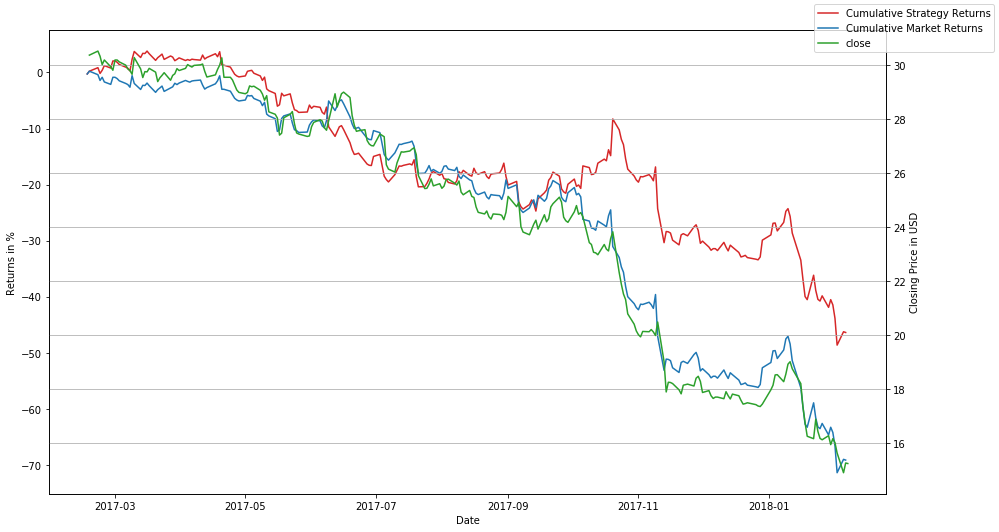

246/246 [==============================] - 0s 24us/step
1229
1229
245


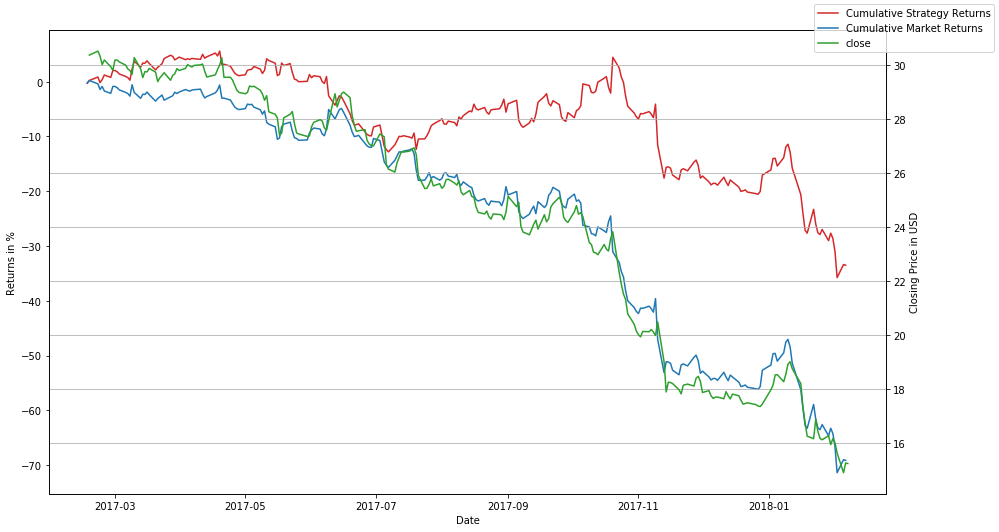

KeyboardInterrupt: 

In [26]:
for pick in range(0,10):
    pick = 'GE'
    df_stock = df.loc[df['Name'] == pick]
    df_stock['date'] = pd.to_datetime(df_stock['date'])
    df_stock['close'] = pd.to_numeric(df_stock['close'], downcast='float')
    
    df_stock.set_index('date',inplace=True)  
    df_stock.sort_index(inplace=True)  
    df_stock = df_stock.loc['2017-02-17':]

    res = ANN(df, pick)
    
    algo = res[3]
    market = res[4]
    close = df_stock['close']
    print(len(algo))
    print(len(market))
    print(len(close))
    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Returns in %', color='k')
    ax1.plot(algo, color=color)
    ax1.tick_params(axis='y', labelcolor='k')
    
    color = 'tab:blue'
    ax1.plot(market, color=color)
    ax1.tick_params(axis='y', labelcolor='k')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'
    ax2.set_ylabel('Closing Price in USD', color='k')  # we already handled the x-label with ax1
    ax2.plot(df_stock['close'], color=color)
    ax2.tick_params(axis='y', labelcolor='k')
    ax2.grid()
    fig.tight_layout()# otherwise the right y-label is slightly clipped
    fig.legend(loc=1)
    fig.set_figwidth(15)
    fig.set_figheight(8)

    plt.show()